# Initialization

In [30]:
import copy

from pathlib import Path
import os
import re

import libpysal
from libpysal.weights import Queen

import pandas as pd
import geopandas as gpd
import numpy as np
from esda.moran import Moran


from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

In [31]:
# This project previously kept the datasets separate until the analysis step, but in the
# current iteration we form and use a singular merged dataframe containing all features
# this part of the code is left as is but not used

files_clean = r'C:\Users\Mustafa\Desktop\asthma analysis\files\cleaned files'
files_clean_path = Path(files_clean)

csv_files = list(files_clean_path.glob('*.csv'))

csv_names_list = [file.stem.replace('.csv', '') for file in csv_files]

# df_list = {}

# for i, entry in enumerate(csv_files):
#     df_list[csv_names_list[i]] = pl.read_csv(entry, infer_schema_length=2000, ignore_errors=True)

In [32]:
# Loading the singular merged dataframe we've created previously
df_merged = pd.read_csv(os.path.join(files_clean, 'merged_asthma_data.csv'), dtype={'FIPS': object})

# We also drop Hawaii, Puerto Rico and Alaska entirely, since they're not really represented in our 
# asthma data but they complicate the spatial weight calculations
states_to_drop = ['Alaska', 'Hawaii', 'Puerto Rico']

df_merged = df_merged[~df_merged['State'].isin(states_to_drop)]

df_merged

,County (State),State,FIPS,State Abbreviation,Land Area,Water Area,Latitude,Longitude,Total => Total population,Total => Total population => SUMMARY INDICATORS => Median age (years),...,"(Household Composition/Disability) Persons aged 17 and younger estimate, 2014-2018 ACS [E_AGE17] (per 100k)","(Household Composition/Disability) Civilian noninstitutiona lized population with a disability estimate, 2014-2018 ACS [E_DISABL] (per 100k)","(Household Composition/Disability) Single parent household with children under 18 estimate, 2014-2018 ACS [E_SNGPNT] (per 100k)","(Minority Status/Language) Minority (all persons except white, non- Hispanic) estimate, 2014-2018 ACS [E_MINRTY] (per 100k)","(Minority Status/Language) Persons (age 5+) who speak English ""less than well"" estimate, 2014-2018 ACS [E_LIMENG] (per 100k)","(Housing Type/Transportation) Housing in structures with 10 or more units estimate, 2014-2018 ACS 2018 DESCRIPTION [E_MUNIT] (per 100k)","(Housing Type/Transportation) At household level (occupied housing units), more people than rooms estimate, 2014-2018 ACS [E_CROWD] (per 100k)","(Housing Type/Transportation) Persons in group quarters estimate, 2014-2018 ACS 2018 DESCRIPTION [E_GROUPQ] (per 100k)","(General) Adjunct variable - Uninsured in the total civilian noninstitutiona lized population estimate, 2014-2018 ACS [E_UNINSUR] (per 100k)","(General) Adjunct variable - Estimated daytime population, LandScan 2018 [E_DAYPOP] (per 100k)"
0,Autauga County (Alabama),Alabama,01001,AL,1.539634e+09,2.567481e+07,32.532237,-86.646440,55380.0,38.2,...,24140.483929,18896.713615,2863.849765,24897.074756,769.230769,1599.855544,539.906103,985.915493,6997.110870,67354.640664
1,Baldwin County (Alabama),Alabama,01003,AL,4.117657e+09,1.132956e+09,30.659218,-87.746067,212830.0,43.0,...,21461.730019,13561.527980,2118.122445,16604.332096,501.808956,9628.341869,465.629845,1416.153738,9803.129258,91940.515905
2,Barbour County (Alabama),Alabama,01005,AL,2.292160e+09,5.052321e+07,31.870253,-85.405104,25361.0,40.4,...,21434.486022,20022.869761,4629.155002,54745.475336,1569.338748,599.345452,1234.178463,11434.880328,10086.353062,98781.593786
3,Bibb County (Alabama),Alabama,01007,AL,1.612189e+09,9.572303e+06,33.015893,-87.127148,22493.0,40.9,...,20713.110746,15169.163740,1809.451829,25456.808785,253.412173,986.973725,231.183035,9296.225492,7197.794870,78673.365047
4,Blount County (Alabama),Alabama,01009,AL,1.670259e+09,1.486028e+07,33.977358,-86.566440,57681.0,40.7,...,23349.109759,14067.023803,2491.288293,12851.718937,1619.250706,365.805031,587.715192,941.384511,10927.341759,69409.337563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3220,Sweetwater County (Wyoming),Wyoming,56037,WY,2.700575e+10,1.662302e+08,41.660328,-108.875677,43521.0,35.3,...,27134.027251,12426.185060,3662.599665,20702.649296,1537.188943,2472.369661,707.704327,1328.094483,12040.164518,105084.901542
3221,Teton County (Wyoming),Wyoming,56039,WY,1.035179e+10,5.708591e+08,44.048662,-110.426087,23280.0,39.3,...,19046.391753,6911.512027,2508.591065,18238.831615,4059.278351,4381.443299,2826.460481,3969.072165,9901.202749,126400.343643
3222,Uinta County (Wyoming),Wyoming,56041,WY,5.391632e+09,1.662582e+07,41.284726,-110.558947,20479.0,35.8,...,29645.002197,17115.093510,2573.367840,12534.791738,649.445774,2519.654280,1069.388154,1284.242395,12202.744275,96362.127057
3223,Washakie County (Wyoming),Wyoming,56043,WY,5.798152e+09,1.041589e+07,43.878831,-107.669052,8027.0,42.9,...,24193.347452,14737.760060,3002.367011,18225.987293,311.448860,535.692039,747.477264,2068.020431,15236.078236,97907.063660


In [33]:
# We fetch the county borders info using pygris live, rather than downloading externally.
# We use the data from year 2020 since most of our data is from that year
# This is done before the analysis rather than during the data cleaning since the geometry
# data is handled differently than regular features in geodataframes, and leaving them
# out of our unified dataframe lets it be compatible with as many systems as possible

import pygris

county_borders = pygris.counties(year=2020, 
                                 cb=True,       # cb=True gets the cartographic boundary file (cleaner for mapping/analysis than TIGER default)
                                 cache=True)    # cache=True saves it locally for future runs

keep_cols = ['GEOID', 
             'STATE_NAME', 
             #'STUSPS', 
             #'ALAND', # Our merged dataframe already has land and water area measurements in it
             #'AWATER', 
             'geometry']
county_borders = (county_borders
                    .drop(columns = [col for col in county_borders.columns if col not in keep_cols])
                    .rename(columns = {
                        'GEOID': 'FIPS',
                        'STATE_NAME': 'State',
                        #'STUSPS': 'State Abbreviation',
                        #'ALAND': 'Land Area',
                        #'AWATER': 'Water Area'
                    }).set_index('FIPS')
)

county_borders = county_borders[~county_borders['State'].isin(states_to_drop)]

county_borders

,State,geometry
FIPS,,
13031,Georgia,"POLYGON ((-82.02684 32.55516, -82.02527 32.558..."
13121,Georgia,"POLYGON ((-84.84931 33.51318, -84.84429 33.514..."
13179,Georgia,"POLYGON ((-81.8244 32.01488, -81.81338 32.0162..."
13189,Georgia,"POLYGON ((-82.64852 33.60838, -82.64409 33.606..."
13213,Georgia,"POLYGON ((-84.94434 34.68004, -84.9431 34.6804..."
...,...,...
41049,Oregon,"POLYGON ((-120.00631 45.27648, -120.00556 45.3..."
21073,Kentucky,"POLYGON ((-85.02426 38.13059, -85.02299 38.131..."
17201,Illinois,"POLYGON ((-89.40142 42.50043, -89.37175 42.500..."


In [ ]:
# Defining the merged geodataframe that'll be used for the rest of the analysis

gdf_merged = county_borders.merge(
        df_merged,
        left_on='FIPS',
        right_on='FIPS',
        how='left',
        validate='1:1',
        suffixes=('', '_y')
    ).set_index('FIPS')

# Making double-sure that Alaska, Hawaii and Puerto Rico are dropped
gdf_merged = gdf_merged[~gdf_merged['State'].isin(states_to_drop)]

# Getting rid of the State_y column that spawns as a result of merging with the county borders data
# These columns are unfortunately not one-to-one, either due to naming convention differences or due to
# an imbalance in represented states. Either way, the extra states and the names in the county borders
# file are not relevant to us
gdf_merged = gdf_merged[[col for col in gdf_merged.columns if col != 'State_y']]

# Dropping counties missing more than 5 features (essentially the extra counties that may exist in the
# borders file, since we've already dropped mostly missing entries in the cleaning process)
gdf_merged = gdf_merged.dropna(axis=0, thresh=5)

gdf_merged

,State,geometry,County (State),State Abbreviation,Land Area,Water Area,Latitude,Longitude,Total => Total population,Total => Total population => SUMMARY INDICATORS => Median age (years),...,"(Household Composition/Disability) Persons aged 17 and younger estimate, 2014-2018 ACS [E_AGE17] (per 100k)","(Household Composition/Disability) Civilian noninstitutiona lized population with a disability estimate, 2014-2018 ACS [E_DISABL] (per 100k)","(Household Composition/Disability) Single parent household with children under 18 estimate, 2014-2018 ACS [E_SNGPNT] (per 100k)","(Minority Status/Language) Minority (all persons except white, non- Hispanic) estimate, 2014-2018 ACS [E_MINRTY] (per 100k)","(Minority Status/Language) Persons (age 5+) who speak English ""less than well"" estimate, 2014-2018 ACS [E_LIMENG] (per 100k)","(Housing Type/Transportation) Housing in structures with 10 or more units estimate, 2014-2018 ACS 2018 DESCRIPTION [E_MUNIT] (per 100k)","(Housing Type/Transportation) At household level (occupied housing units), more people than rooms estimate, 2014-2018 ACS [E_CROWD] (per 100k)","(Housing Type/Transportation) Persons in group quarters estimate, 2014-2018 ACS 2018 DESCRIPTION [E_GROUPQ] (per 100k)","(General) Adjunct variable - Uninsured in the total civilian noninstitutiona lized population estimate, 2014-2018 ACS [E_UNINSUR] (per 100k)","(General) Adjunct variable - Estimated daytime population, LandScan 2018 [E_DAYPOP] (per 100k)"
FIPS,,,,,,,,,,,,,,,,,,,,,
13031,Georgia,"POLYGON ((-82.02684 32.55516, -82.02527 32.558...",Bulloch County (Georgia),GA,1.750735e+09,32827779.0,32.394481,-81.741618,76120.0,28.8,...,19695.218077,12930.898581,4123.751971,35622.700998,398.055702,3594.324750,852.601156,10693.641618,13012.348923,98152.916448
13121,Georgia,"POLYGON ((-84.84931 33.51318, -84.84429 33.514...",Fulton County (Georgia),GA,1.364275e+09,19524189.0,33.790034,-84.468182,1036200.0,35.5,...,22222.736923,9904.072573,3746.767033,59365.662999,1897.124107,14306.794055,714.919900,3355.240301,10716.850029,112401.370392
13179,Georgia,"POLYGON ((-81.8244 32.01488, -81.81338 32.0162...",Liberty County (Georgia),GA,1.337654e+09,222884791.0,31.807458,-81.457871,61349.0,28.4,...,28642.683662,12482.681054,5450.781594,61130.580776,1377.365564,2534.678642,1041.581770,3326.867594,11397.088787,90418.751732
13189,Georgia,"POLYGON ((-82.64852 33.60838, -82.64409 33.606...",Mcduffie County (Georgia),GA,6.665900e+08,23114032.0,33.480613,-82.479533,21455.0,37.7,...,25541.831741,13731.065020,5816.825915,46310.883244,652.528548,2097.413190,824.982522,1435.562806,13176.415754,85266.837567
13213,Georgia,"POLYGON ((-84.94434 34.68004, -84.9431 34.6804...",Murray County (Georgia),GA,8.922351e+08,5719643.0,34.797097,-84.737990,39724.0,38.2,...,24989.930521,14328.869197,2967.979055,17042.593898,2809.384755,176.215890,1152.955392,578.995066,16760.648474,84500.553821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41049,Oregon,"POLYGON ((-120.00631 45.27648, -120.00556 45.3...",Morrow County (Oregon),OR,5.259046e+09,44372730.0,45.425496,-119.602311,11303.0,38.9,...,27824.471379,15553.392905,2627.620986,39821.286384,8334.070601,1132.442714,3096.523047,451.207644,9714.235159,103034.592586
21073,Kentucky,"POLYGON ((-85.02426 38.13059, -85.02299 38.131...",Franklin County (Kentucky),KY,5.383122e+08,10786432.0,38.234919,-84.868786,50529.0,40.9,...,20885.036316,16675.572444,3760.216905,18183.617329,1195.353164,3716.677552,835.163965,3498.980783,7918.225178,113554.592412
17201,Illinois,"POLYGON ((-89.40142 42.50043, -89.37175 42.500...",Winnebago County (Illinois),IL,1.328793e+09,15873993.0,42.337396,-89.161205,284819.0,39.7,...,23760.001966,13880.745315,4714.924215,30507.445079,2099.579031,3441.132790,858.439921,1494.984534,6511.503797,96544.121003


# Spatial Filtering Eigenvectors

In [ ]:
# Calculating the spatial filtering eigenvectors, which will help us detect spatial patterns during the actual analysis
MORAN_THRESHOLD = 0.25

# Setting the weights
# We use binary (0/1) weights for the spectral decomposition to maintain symmetry.
w_master = libpysal.weights.Queen.from_dataframe(gdf_merged, use_index=True)

# Handling the islands
# Ideally, we explicitly set them to 0. Libpysal does this by default for unconnected nodes
# if we don't force a transformation.
if w_master.islands:
    print(f'=== Found {len(w_master.islands)} islands. They will have 0 eigenvectors. ===')
    # Re-build to ensure indices align perfectly if there were drops, 
    # though usually keeping the full shape is safer for alignment.
    w_master = libpysal.weights.Queen.from_dataframe(gdf_merged, use_index=True, ids=gdf_merged.index.tolist())

# Ensuring no transformation is applied yet
w_master.transform = 'O' 

# Matrix algebra for eigenvectors
# Getting the full dense matrix (0s and 1s)
C_matrix = w_master.full()[0]
n = C_matrix.shape[0]

# Centering Matrix: M = I - 11'/n
M = np.identity(n) - (np.ones((n, n)) / n)

# Setting the centered connectivity matrix
# Since M and C are symmetric, m_centered will be symmetric.
m_centered = M @ C_matrix @ M

# Eigendecomposition
evals, evecs = np.linalg.eigh(m_centered)

# Sort strictly descending (positive eigenvalues = positive spatial autocorrelation)
idx_sorted = np.argsort(evals)[::-1]
evals, evecs = evals[idx_sorted], evecs[:, idx_sorted]

# Selection and filtering
# Eigenvalues of a binary matrix are NOT directly Moran's I values (-1 to 1).
# They are scaled by the sum of weights.
# However, the ratio (val / sum_of_weights * n) approximates Moran's I.
# Most implementations simply take the top K positive eigenvectors.

# Calculating the scaling factor specific to the dataset to approximate Moran's I
scaling_factor = n / np.sum(C_matrix)
morans_i_equivalent = evals * scaling_factor

# Filtering based on the converted metric
mask = morans_i_equivalent > MORAN_THRESHOLD
selected_evecs = evecs[:, mask]
selected_evals = evals[mask]

print(f'Selected {selected_evecs.shape[1]} eigenvectors with Moran's I > {MORAN_THRESHOLD}')

# Saving the results
sf_cols = [f'SF_{i}' for i in range(selected_evecs.shape[1])]
df_sf = pd.DataFrame(selected_evecs, columns=sf_cols, index=gdf_merged.index)

df_sf

C:\Users\Mustafa\Desktop\asthma analysis\.conda\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 7 islands with ids: 78010, 78020, 53055, 78030, 36085, 25007, 25019.
  W.__init__(self, neighbors, ids=ids, **kw)


=== Found 7 islands. They will have 0 eigenvectors. ===
Selected 793 eigenvectors with Moran's I > 0.25


,SF_0,SF_1,SF_2,SF_3,SF_4,SF_5,SF_6,SF_7,SF_8,SF_9,...,SF_783,SF_784,SF_785,SF_786,SF_787,SF_788,SF_789,SF_790,SF_791,SF_792
FIPS,,,,,,,,,,,,,,,,,,,,,
13031,-0.003405,0.005804,-0.007428,0.000800,-0.009896,0.019535,-0.046234,0.017273,-0.008762,0.018787,...,-0.020127,0.027908,0.007143,-0.007560,-0.004572,0.005620,0.009882,-0.006648,-0.011154,-0.001813
13121,-0.005775,0.010086,-0.013823,0.001542,-0.020572,0.041775,-0.096906,0.022694,-0.026141,0.047385,...,0.006374,-0.045197,-0.005907,-0.007475,-0.009355,-0.014234,-0.027327,-0.006222,-0.031825,0.021042
13179,-0.001844,0.003071,-0.003708,0.000389,-0.004562,0.008765,-0.020669,0.007703,-0.004022,0.008805,...,0.046061,-0.043106,0.002412,-0.027147,-0.003133,-0.007269,-0.012177,0.014755,0.025614,0.022139
13189,-0.003217,0.005551,-0.007399,0.000816,-0.010681,0.021679,-0.051273,0.018707,-0.009278,0.018688,...,0.013876,0.009341,-0.007417,0.010538,-0.029714,-0.003286,-0.017892,0.016108,0.054126,0.003339
13213,-0.003410,0.005868,-0.007710,0.000840,-0.010574,0.020349,-0.046142,0.009992,-0.011865,0.020609,...,-0.031825,-0.054494,-0.043102,-0.008598,-0.011704,-0.000083,-0.027268,-0.010794,-0.023862,-0.003423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41049,-0.003599,0.006155,0.000756,0.000424,-0.006972,-0.059391,0.000565,0.019300,-0.016486,0.028091,...,0.004168,-0.002945,-0.016920,0.016307,-0.006094,-0.007697,0.000031,0.004079,0.008928,0.011140
21073,-0.002522,0.004097,-0.004332,0.000363,-0.002489,0.000728,0.001516,-0.000765,0.003616,-0.003739,...,-0.045265,-0.018289,-0.006541,-0.022382,0.006991,-0.024306,-0.014340,-0.013271,-0.016267,0.001555
17201,0.001594,0.002988,-0.004337,-0.019958,0.000572,0.000150,0.005025,0.000875,0.002078,-0.005197,...,0.017196,-0.000612,-0.027544,0.010714,0.000818,-0.008288,0.002167,-0.014375,0.012126,0.000028


In [ ]:
# We will also need a constrained weights matrix for the features that are impacted by state borders,
# such as insurance and education related ones. These will follow a different logic when imputing
# and generating the spatial lags.

# Copying the master weights
w_constrained = copy.deepcopy(w_master)

# Getting the states list
state_lookup = gdf_merged['State']

# Iterating through every node to filter neighbors
for idx in w_constrained.id_order:
    current_state = state_lookup.loc[idx]
    original_neighbors = w_constrained.neighbors[idx]
    
    # Keeping only neighbors that share the same state
    valid_neighbors = [
        n for n in original_neighbors 
        if state_lookup.loc[n] == current_state
    ]
    
    # Updating the weights object
    w_constrained.neighbors[idx] = valid_neighbors
    
    # Updating the weights values (keeping them uniform or matching original style)
    # For simplicity in imputation, we usually just want connectivity (1.0)
    w_constrained.weights[idx] = [1.0] * len(valid_neighbors)
    
# Row-standardizing the constrained matrix.
if w_constrained.islands:
    print(f'=== Warning: State restrictions created {len(w_constrained.islands)} new isolated counties ===')
    # We silence the division-by-zero error by explicitly handling islands
    # This creates a subset W that ignores the islands.
    # The safest generic fix is to rebuild W excluding the islands, similar to how we handled the master W:
    valid_ids = [i for i in gdf_merged.index if i not in w_constrained.islands]


# Row-standardizing the matrices
w_constrained.transform = 'r'

w_master.transform = 'r'

=== Warning: State restrictions created 7 new isolated counties ===
('WARNING: ', '78010', ' is an island (no neighbors)')
('WARNING: ', '78020', ' is an island (no neighbors)')
('WARNING: ', '11001', ' is an island (no neighbors)')
('WARNING: ', '53055', ' is an island (no neighbors)')
('WARNING: ', '78030', ' is an island (no neighbors)')
('WARNING: ', '44005', ' is an island (no neighbors)')
('WARNING: ', '36085', ' is an island (no neighbors)')
('WARNING: ', '25007', ' is an island (no neighbors)')
('WARNING: ', '25019', ' is an island (no neighbors)')
('WARNING: ', '78010', ' is an island (no neighbors)')
('WARNING: ', '78020', ' is an island (no neighbors)')
('WARNING: ', '53055', ' is an island (no neighbors)')
('WARNING: ', '78030', ' is an island (no neighbors)')
('WARNING: ', '36085', ' is an island (no neighbors)')
('WARNING: ', '25007', ' is an island (no neighbors)')
('WARNING: ', '25019', ' is an island (no neighbors)')


# Feature Filtering per Target

In [37]:
id_columns = ['County (State)', 'County', 'State', 'FIPS', 'Latitude', 'Longitude']
asthma_columns = ['Age-adjusted ER Visit Rate for Asthma per 10,000 People',
                  'Age-adjusted Hospitalization Rate for Asthma per 10,000 People']

In [ ]:
# We have roughly 1500 counties with ER data and 1000 with hospitalization data, and features that are missing from too many of these counties
# is not only useless but potentially harmful for our analysis. We use a function to filter the features that are present in at least 20%
# of the counties that have data for our target features. This'll output one list per feature, since one feature might be missing from 1000 counties,
# none of whom have asthma-related ER visit data anyway, at which point that feature is completely irrelevant to the ER analysis, but that's not going to 
# necessarily be the case for the hospitalization rates (and vice versa)

def get_valid_features_for_target(df, target_col, exclude_cols=[], threshold=0.3):
    # Filtering to rows where the target exists
    target_subset = df[df[target_col].notnull()]
    total_rows = len(target_subset)
    
    if total_rows == 0:
        print(f'Warning: No valid rows found for target "{target_col}"')
        return []

    protected_cols = set(exclude_cols) | {target_col}

    # Calculating null counts for all columns in the subset
    null_counts = target_subset.isnull().sum()
    
    # Filtering columns based on the threshold and exclusion list
    cols_to_drop = []
    for col_name, null_count in null_counts.items():
        missing_ratio = null_count / total_rows
        
        if missing_ratio >= threshold and col_name not in protected_cols:
            cols_to_drop.append(col_name)
            
    print(f'For target "{target_col}": Dropped {len(cols_to_drop)} features out of {len(df.columns)} (Threshold: {threshold*100}%).')
    return cols_to_drop

##########################################################

er_features = get_valid_features_for_target(df = df_merged, 
                                            target_col = asthma_columns[0], 
                                            exclude_cols = asthma_columns[1],
                                            threshold = 0.2)


hosp_features = get_valid_features_for_target(df = df_merged, 
                                              target_col = asthma_columns[1], 
                                              exclude_cols = asthma_columns[0],
                                              threshold = 0.2)

For target "Age-adjusted ER Visit Rate for Asthma per 10,000 People": Dropped 8 features out of 357 (Threshold: 20.0%).
For target "Age-adjusted Hospitalization Rate for Asthma per 10,000 People": Dropped 4 features out of 357 (Threshold: 20.0%).


# Imputing prep

In [ ]:
# When imputing, we will check whether the feature is 'smooth' or 'discrete' and treat it accordingly.
# Features like air quality and population may have a natural distribution, but features that have to do
# with data impacted by state-level differences, like how insurance is handled, can have abrupt differences
# across state borders and end up being more similar in counties in the same state even if there are counties
# that are technically closer or with more shared borders but in different states.

def get_hard_constraint_cols(df, keywords):
    '''
    Returns a list of column names that contain any of the keywords (case-insensitive).
    '''
    # Getting all column names
    all_cols = df.columns
    
    # Finding matches
    # We use .lower() to ensure 'Medicaid' matches 'medicaid'
    matches = [
        col for col in all_cols 
        if any(keyword.lower() in col.lower() for keyword in keywords)
    ]
    
    return list(set(matches)) # Remove duplicates just in case

###########################################################

# Defining the words that imply a state-level policy boundary
policy_keywords = [
    'medicaid', 'insurance', 'enrollment', 'medicare'               # Health Policy-related
    'tax', 'spending', 'funding',                                   # Fiscal Policy-related
    'graduation', 'proficiency', 'score', 'college', 'education'    # Education, since people are more likely to go to universities in-state to avoid high tuition
    'crime', 'arrest'                                               # Legal/Reporting Standards
]

# Generating the list automatically
hard_cutoff_list = get_hard_constraint_cols(df_merged, policy_keywords)

print(f'=== Found {len(hard_cutoff_list)} columns to apply hard state constraints: ===')
for i in hard_cutoff_list:
    print(i)

=== Found 52 columns to apply hard state constraints: ===
Percent Private Coverage => Civilian noninstitutionalized population => PRIVATE INSURANCE ALONE OR IN COMBINATION => At or above 138 percent of the poverty threshold
Percent Private Coverage => Civilian noninstitutionalized population => COVERAGE ALONE OR IN COMBINATION => Employer-based insurance alone or in combination
Percent Public Coverage => COVERAGE ALONE OR IN COMBINATION => Medicaid/means-tested public coverage alone or in combination => Under 19
Percent Private Coverage => Civilian noninstitutionalized population => PRIVATE INSURANCE ALONE OR IN COMBINATION => 75 years and over
Percent Public Coverage => COVERAGE ALONE OR IN COMBINATION => Medicaid/means-tested public coverage alone or in combination
Percent Public Coverage => PUBLIC INSURANCE ALONE OR IN COMBINATION => Worked full-time, year-round (19-64 years)
High school graduation => Cohort Size
Percent Private Coverage => Civilian noninstitutionalized population =

In [ ]:
# We will also use spatial lag features to help with imputing and analysis, and to identify which
# features are appropriate to generate lags for, we check both completeness and spatial autocorrelation
# We also use the generated hard cutoff list and the constrained weights for the state-level features

def select_optimal_anchors(df, 
                           w_global, 
                           w_constrained, 
                           hard_cutoff_list = None,
                           exclude_list = None,
                           completeness_threshold = 0.95, 
                           morans_threshold = 0.1):
    
    if hard_cutoff_list is None: hard_cutoff_list = []


    completeness = 1 - df.isnull().mean()
    candidates = completeness[completeness >= completeness_threshold].index.tolist()
    # Filter for numeric only
    candidates = [c for c in candidates if pd.api.types.is_numeric_dtype(df[c])]
    
    print(f'Candidates for checking: {len(candidates)}')
    valid_anchors = []

    for col in candidates:
        if col in hard_cutoff_list:
            parent_w = w_constrained
        else:
            parent_w = w_global

        # Dropping NaNs for this specific feature
        valid_series = df[col].dropna()
        valid_indices = valid_series.index.tolist()
        
        # Skipping if we have less than 30 candidates
        if len(valid_indices) < 30: continue

        try:
            ################ Subset Logic ################
            # Getting the weights matrix subset for our candidate features
            w_subset = libpysal.weights.w_subset(parent_w, valid_indices, silence_warnings=True)
            

            # 'r' (row-standardize) will fail or warn if there are islands (division by zero).
            try:
                w_subset.transform = 'r'
            except ZeroDivisionError:
                # If islands exist, standardizing fails.
                # Simplest fix: Force islands to have 0 weights
                for iso in w_subset.islands:
                    w_subset.weights[iso] = []
                w_subset.transform = 'r'
            
            # Moran's I using ESDA
            mi = Moran(valid_series.values, w_subset)
            
            # Adding the candidate to the anchors list if it meets our Moran's I expectations with p-value <0.05
            if mi.I > morans_threshold and mi.p_sim < 0.05 and col not in exclude_list:
                valid_anchors.append(col)
                # print(f'  Selected {col} (I={mi.I:.2f})')

        except Exception as e:
            print(f'[!] Skipped {col} due to error: {e}')
            continue

    return valid_anchors

#############################################

real_anchors = select_optimal_anchors(df = gdf_merged, 
                                      w_global = w_master,            # Standardized Global
                                      w_constrained = w_constrained,  # Standardized Constrained
                                      hard_cutoff_list = hard_cutoff_list,
                                      exclude_list = ['Latitude', 'Longitude'],
                                      completeness_threshold = 0.95,
                                      morans_threshold = 0.25)


print(f'Final Selected Anchors: {len(real_anchors)} (Complete + Spatially Clustered)')
for i in real_anchors:
    print(i)

Candidates for checking: 327
Final Selected Anchors: 234 (Complete + Spatially Clustered)
Land Area
Water Area
Total => Total population
Total => Total population => SUMMARY INDICATORS => Median age (years)
Total => Total population => SUMMARY INDICATORS => Age dependency ratio
Total => Total population => SUMMARY INDICATORS => Old-age dependency ratio
Total => Total population => SUMMARY INDICATORS => Child dependency ratio
Percent => Total population => AGE => Under 5 years
Percent => Total population => AGE => 5 to 9 years
Percent => Total population => AGE => 45 to 49 years
Percent => Total population => AGE => 50 to 54 years
Percent => Total population => AGE => 60 to 64 years
Percent => Total population => AGE => 65 to 69 years
Percent => Total population => AGE => 70 to 74 years
Percent => Total population => AGE => 75 to 79 years
Percent => Total population => AGE => 80 to 84 years
Percent => Total population => AGE => 85 years and over
Percent => Total population => SELECTED A

In [ ]:
# When generating the spatial lag features, we use the anchors detected in the previous step,
# and create the lags using only in-state neighbors if they also happen to be in the hard cutoff list

def create_hybrid_spatial_lags(df, 
                               w_global, 
                               w_constrained, 
                               anchor_features, 
                               hard_cutoff_list = None):
    '''
    Hybrid Imputation & Lag Generation:
    - Uses w_constrained for 'hard_cutoff_list' features (State Policies, Insurance).
    - Uses w_global for continuous features (Air Quality, Weather).
    '''

    if hard_cutoff_list is None:
        hard_cutoff_list = []

    lag_column_list = []
    print(f'=== Processing {len(anchor_features)} features ===')

    for col in anchor_features:
        if not pd.api.types.is_numeric_dtype(df[col]):
            continue
            
        # Selecting the correct weights based on whether the feature is in the
        # hard cutoff list
        if col in hard_cutoff_list:
            current_w = w_constrained
        else:
            current_w = w_global
            
        # Imputation Setup
        filled_series = df[col].copy()
        global_median = df[col].median()
        missing_indices = df.index[df[col].isnull()]
        
        # Filling in missing values
        for idx in missing_indices:
            try:
                # Using the selected W to get neighbors
                neighbor_ids = current_w.neighbors[idx]
                
                # Getting neighbor values
                if not neighbor_ids:
                    neighbor_values = pd.Series(dtype='float64')
                else:
                    neighbor_values = df.loc[neighbor_ids, col].dropna()
                
                # Calculating neighbor values' mean if they exist, using global median if island
                if not neighbor_values.empty:
                    filled_series.at[idx] = neighbor_values.mean()
                else:
                    filled_series.at[idx] = global_median
            # Fallback global median        
            except KeyError:
                filled_series.at[idx] = global_median

        # Generating Final Spatial Lag
        # We pass the same current_w here. 
        # If it's a hard cutoff var, the lag will effectively be 'Average of IN-STATE neighbors'
        
        # Ensuring weights are row-standardized for the lag calculation (interpretation = average)
        current_w.transform = 'R' 
        
        final_lag = libpysal.weights.lag_spatial(current_w, filled_series.values)
        lag_column_list.append(pd.Series(final_lag, name=f'{col} (Lag)', index=df.index))

    # Merging the results
    if lag_column_list:
        df_lags = pd.concat(lag_column_list, axis=1)
        return pd.concat([df, df_lags], axis=1)
    
    return df

#######################################################

gdf_lagged = create_hybrid_spatial_lags(gdf_merged, 
                                        w_global = w_master, 
                                        w_constrained = w_constrained, 
                                        anchor_features = real_anchors, 
                                        hard_cutoff_list = hard_cutoff_list)

=== Processing 234 features ===


In [ ]:
# There are certain steps where we don't want the code to run on spatial lag features.
# The hard cutoff features' lags should also technically be considered hard cutoff features,
# so we expand the list to include them as well.

# Creating the hard cutoff list that includes their lagged variants
anchors_set = set(real_anchors)

lagged_cutoff_list = list(hard_cutoff_list)

# Iterating through the hard features to find their lagged cousins
for feature in hard_cutoff_list:
    lag_name = f'{feature} (Lag)'
    
    # If the lag exists in the valid anchors list, we add it to the hard cutoff list
    if feature in anchors_set:
        lagged_cutoff_list.append(lag_name)

# Removing duplicates just in case
lagged_cutoff_list = list(set(lagged_cutoff_list))

print(f'Expanded Hard Cutoff List: {len(hard_cutoff_list)} -> {len(lagged_cutoff_list)} features')

Expanded Hard Cutoff List: 52 -> 101 features


In [ ]:
# We are now ready for the imputation process, which will be done in three passes:
# First we impute only the smooth features using the total dataset, and re-generate the lags.
# Having generated the lags previously provides more context for imputing, but imputing the missing
# lag entries is slower and less reliable than just re-generating them.

# Then we go state by state to impute the hard cutoff features. Unfortunately iterative imputing
# algorithms in scikit cannot work in such a way as to use certain features across all states for context
# and limit the imputing to specific conditions (in this case, imputing only in one state at a time)
# This means we have to iterate over every state when imputing the hard cutoff features, meaning the
# algorithm loses the context generated by the out-of-state counties.

# Finally, we impute everything once more, just to be absolutely certain we have no null entries.

def three_pass_imputation(gdf, lagged_cutoff_list, asthma_columns, w_global, random_state=2211):
    
    print('=== Starting Three-Pass Spatial Imputation ===')
    
    ###################### PREPARATION ######################
    geometry = gdf.geometry
    non_numeric = gdf.select_dtypes(exclude=[np.number, 'geometry'])
    df_numeric = gdf.select_dtypes(include=[np.number])
    
    # Feature Sets
    targets = [c for c in df_numeric.columns if c in asthma_columns]
    
    # Hard Features (Base + Lags)
    hard_features = [
        c for c in df_numeric.columns 
        if c in lagged_cutoff_list and c not in asthma_columns
    ]
    
    # Smooth Features (Base only, no Lags)
    smooth_features_base = [
        c for c in df_numeric.columns 
        if c not in targets 
        and c not in hard_features 
        and ' (Lag)' not in c
    ]
    
    print(f'=== Pass 1 Target: {len(smooth_features_base)} Smooth Features (Global) ===')
    print(f'=== Pass 2 Target: {len(hard_features)} Hard Features (State-Local) ===')



    ###################### PASS 1: GLOBAL IMPUTATION (Smooth Base) ######################
    print('\n=== Pass 1: Global Imputation (Smooth Base Features) ===')
    
    pass1_cols = smooth_features_base + targets 
    pass1_data = df_numeric[pass1_cols].copy()
    
    imputer_global = IterativeImputer(
        estimator=RandomForestRegressor(n_estimators=15, n_jobs=-1, random_state=random_state),
        max_iter=5,
        random_state=random_state,
        verbose=2
    )
    
    pass1_imputed = imputer_global.fit_transform(pass1_data)
    df_pass1 = pd.DataFrame(pass1_imputed, columns=pass1_cols, index=df_numeric.index)
    


    ###################### INTERMEDIATE: Recalculate Smooth Lags ######################
    print('=== Recalculating spatial lags for smooth features ===')
    df_hybrid = df_pass1.copy()
    
    # Addding back empty hard features
    for hf in hard_features:
        df_hybrid[hf] = df_numeric[hf]
        
    # Recalculating the lags
    for base_col in smooth_features_base:
        lag_name = f'{base_col} (Lag)'
        if lag_name in df_numeric.columns:
            try:
                df_hybrid[lag_name] = libpysal.weights.lag_spatial(w_global, df_hybrid[base_col])
            except:
                df_hybrid[lag_name] = df_hybrid[base_col].median()

    df_hybrid['State'] = gdf['State']



    ###################### PASS 2: LOCAL IMPUTATION (Hard Features) ######################
    print(f'\n=== Pass 2: Local Imputation by State ({len(hard_features)} features) ===')
    
    predictors = [c for c in df_hybrid.columns if c not in hard_features and c != 'State']
    final_chunks = []
    unique_states = df_hybrid['State'].unique()
    
    for i, (state_name, state_group) in enumerate(df_hybrid.groupby('State')):
        
        # Periodic logging
        if (i + 1) % 10 == 0: 
             print(f'  > Processing State {i+1}/{len(unique_states)}...')
            
        # Checking if the state has features that need to be imputed
        if state_group[hard_features].isnull().sum().sum() == 0:
            final_chunks.append(state_group)
            continue
            
        local_cols = predictors + hard_features
        local_data = state_group[local_cols]
        
        # Checking if state has enough data to impute with only in-state data
        if len(local_data) < 5 or local_data.isnull().all().all():
            # Skip imputation for this state if there are less than 5 data points
            final_chunks.append(state_group)
            continue
        
        # Defining the imputer
        imputer_local = IterativeImputer(
            estimator=RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=random_state),
            max_iter=5,
            random_state=random_state,
            verbose=0 
        )
        
        # Attempting the impute
        try:
            local_imputed_vals = imputer_local.fit_transform(local_data)
            df_local = pd.DataFrame(local_imputed_vals, columns=local_cols, index=state_group.index)
            df_local['State'] = state_name
            final_chunks.append(df_local)
        except ValueError:
            # Fallback if local imputation crashes
            final_chunks.append(state_group)

    # Adding the result back to the 'final' dataframe
    df_semi_final = pd.concat(final_chunks).sort_index()



    ###################### PASS 3: GLOBAL CLEANUP (Fallback) ######################
    print('\n=== Pass 3: Global Cleanup (Filling Skipped States) ===')
    
    # Identifying what's still missing (excluding 'State')
    cols_to_check = [col for col in df_semi_final.columns if col != 'State']
    remaining_nans = df_semi_final[cols_to_check].isnull().sum().sum()
    
    if remaining_nans > 0:
        print(f'=== Found {remaining_nans} missing values. Imputing with global trends')
        
        # We drop State/Targets to focus on filling the holes in Hard Features
        # using the now-complete Smooth Features as predictors.
        cleanup_cols = [c for c in cols_to_check if c not in targets]
        
        # We need a numeric-only df for this
        cleanup_data = df_semi_final[cleanup_cols]
        
        imputer_cleanup = IterativeImputer(
            estimator=RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=random_state),
            max_iter=3,
            random_state=random_state,
            verbose=1
        )
        
        cleaned_vals = imputer_cleanup.fit_transform(cleanup_data)
        df_cleaned = pd.DataFrame(cleaned_vals, columns=cleanup_cols, index=df_semi_final.index)
        
        # Updating the semi-final dataframe
        df_semi_final.update(df_cleaned)
        print('=== Cleanup complete. ===')
    else:
        print('=== No remaining missing values. Pass 3 skipped. ===')

    ###################### FINAL REASSEMBLY ######################
    print('\n=== Final Reassembly ===')
    
    # Merging numeric data with geometry
    gdf_final = gpd.GeoDataFrame(
        df_semi_final.drop(columns=['State']), 
        geometry=geometry,
        crs=gdf.crs
    )
    
    # Adding back non-numeric (Categorical/String) columns
    gdf_final = pd.concat([gdf_final, non_numeric], axis=1)
    
    # Ensuring targets are original (prevent accidental imputation)
    for t in targets:
        gdf_final[t] = df_numeric[t]
        
    print('=== Imputation Complete ===')
    return gdf_final

# Imputing

In [ ]:
# Since imputing is time-consuming this code block either imputes and saves the results
# or loads the results from disk depending on below variable

IMPUTING = False

results_folder = r'C:\Users\Mustafa\Desktop\asthma analysis\files\results'

if not os.path.exists(results_folder):
    os.makedirs(results_folder)

imputed_path = os.path.join(results_folder, 'imputed_asthma_data.gpkg')

###############################################

if IMPUTING:
    print('=== Starting Spatial MissForest Imputation ===')

    gdf_imputed = three_pass_imputation(gdf_lagged,
                                        lagged_cutoff_list,
                                        asthma_columns,
                                        w_master,
                                        random_state=2211)

    print(f'Saving to {imputed_path}...')
    gdf_imputed.to_file(imputed_path, driver='GPKG')

###############################################

else:
    print(f'Loading from {imputed_path}...')
    gdf_imputed = gpd.read_file(imputed_path)

    # Ensuring index is restored (GeoPackage resets index usually)
    gdf_imputed = gdf_imputed.set_index('FIPS', drop=False)

###############################################

print('Imputation pipeline complete.')
gdf_imputed.head()


Loading from C:\Users\Mustafa\Desktop\asthma analysis\files\results\imputed_asthma_data.gpkg...
Imputation pipeline complete.


,FIPS,Land Area,Water Area,Latitude,Longitude,Total => Total population,Total => Total population => SUMMARY INDICATORS => Median age (years),Total => Total population => SUMMARY INDICATORS => Sex ratio (males per 100 females),Total => Total population => SUMMARY INDICATORS => Age dependency ratio,Total => Total population => SUMMARY INDICATORS => Old-age dependency ratio,...,"(Household Composition/Disability) Civilian noninstitutiona lized population with a disability estimate, 2014-2018 ACS [E_DISABL] (per 100k) (Lag)","(Minority Status/Language) Minority (all persons except white, non- Hispanic) estimate, 2014-2018 ACS [E_MINRTY] (per 100k) (Lag)","(Minority Status/Language) Persons (age 5+) who speak English ""less than well"" estimate, 2014-2018 ACS [E_LIMENG] (per 100k) (Lag)","(Housing Type/Transportation) Housing in structures with 10 or more units estimate, 2014-2018 ACS 2018 DESCRIPTION [E_MUNIT] (per 100k) (Lag)","(Housing Type/Transportation) At household level (occupied housing units), more people than rooms estimate, 2014-2018 ACS [E_CROWD] (per 100k) (Lag)","(General) Adjunct variable - Uninsured in the total civilian noninstitutiona lized population estimate, 2014-2018 ACS [E_UNINSUR] (per 100k) (Lag)",State,County (State),State Abbreviation,geometry
FIPS,,,,,,,,,,,,,,,,,,,,,
01001,01001,1.539634e+09,2.567481e+07,32.532237,-86.646440,55380.0,38.2,94.7,63.4,24.4,...,18665.478925,52569.466911,780.087245,1231.083561,855.062458,10695.526967,Alabama,Autauga County (Alabama),AL,"MULTIPOLYGON (((-86.9212 32.65754, -86.92035 3..."
01003,01003,4.117657e+09,1.132956e+09,30.659218,-87.746067,212830.0,43.0,94.7,71.5,34.3,...,16806.703538,41176.822519,478.413469,1823.900281,671.290819,11529.994466,Alabama,Baldwin County (Alabama),AL,"MULTIPOLYGON (((-88.02858 30.22676, -88.02399 ..."
01005,01005,2.292160e+09,5.052321e+07,31.870253,-85.405104,25361.0,40.4,112.4,65.3,30.7,...,17827.738068,55385.896020,1860.745094,733.401618,616.855556,13838.350476,Alabama,Barbour County (Alabama),AL,"MULTIPOLYGON (((-85.74803 31.61918, -85.74544 ..."
01007,01007,1.612189e+09,9.572303e+06,33.015893,-87.127148,22493.0,40.9,117.5,57.5,25.1,...,16982.202125,43639.705338,936.250889,3327.520155,783.978134,9834.048714,Alabama,Bibb County (Alabama),AL,"MULTIPOLYGON (((-87.42194 33.00338, -87.33177 ..."
01009,01009,1.670259e+09,1.486028e+07,33.977358,-86.566440,57681.0,40.7,97.6,69.8,30.4,...,17887.005375,20523.012219,1262.975587,1823.086800,624.945503,10639.543805,Alabama,Blount County (Alabama),AL,"MULTIPOLYGON (((-86.96336 33.85822, -86.95967 ..."


# Interaction Features

In [ ]:
# We already have spatial filtering eigenvectors and spatial lags, but we can also generate the interaction 
# features for features that we expect to either be connected to one another somehow or have a compounding 
# effect on asthma outcomes. We will define a function to take in two string lists that iterate through
# features to create these interaction terms later, but for now we define the list pairs.

# The function includes ANY feature that contains ANY of the strings in a list in its name, since we
# have a lot of features with naming conventions of varying complexity, so the lists can be
# pretty loose when it comes to composition

interaction_pairs = {}

############# 1) Pollution burden × socioeconomic vulnerability (classic environmental justice effect modification)
interaction_pairs['pollution_x_socioeconomic'] = [[
    'Value_Pollutant'
],[
    'Poverty', 'EP_POV', 'EPL_POV',
    'Income', 'PCI', 'Unemployment', 'UNEMP', 'EP_UNEMP', 'EPL_UNEMP',
    'no high school diploma', 'NOHSDP', 'EP_NOHSDP', 'EPL_NOHSDP',
    'Free or Reduced Lunch', 'Food insecurity'
]]


############# 2) Pollution burden × race/segregation/minority/language (differential exposure + structural factors)
interaction_pairs['pollution_x_race_segregation_language'] = [[
    'Value_Pollutant'
],[
    'Demographics => % African American', 'Demographics => % Hispanic',
    'Demographics => % Non-Hispanic White', 'Demographics => % Asian',
    'Minority', 'MINRTY', 'EP_MINRTY', 'EPL_MINRTY',
    'Segregation',
    'Not Proficient in English', 'limited English', 'LIMENG', 'EP_LIMENG', 'EPL_LIMENG'
]]


############# 3) Pollution burden × age structure (children/older adults are more susceptible)
interaction_pairs['pollution_x_age_summary'] = [[
    'Value_Pollutant'
],[
    'Demographics => % < 18', 'Under 18 years', 'Under 19', 'Under 6', 'Under 5 years',
    'Demographics => % 65 and over', '65 years and over', '75 years and over', '60 years and over',
    'Median age', 'Age dependency ratio', 'Child dependency ratio', 'Old-age dependency ratio',
    'EP_AGE17', 'EPL_AGE17', 'EP_AGE65', 'EPL_AGE65'
]]


############# 4) Pollution burden × smoking (airway irritant synergy)
interaction_pairs['pollution_x_smoking'] = [[
    'Value_Pollutant'
],[
    'Adult smoking', '% Smokers'
]]


############# 5) Pollution burden × cardiometabolic comorbidity (worse baseline health → higher acute care use)
interaction_pairs['pollution_x_comorbidity'] = [[
    'Value_Pollutant'
],[
    'Adult obesity', '% Obese',
    'Diabetes prevalence', '% Diabetic',
    'Poor or fair health', '% Fair/Poor',
    'Frequent physical distress', 'Physically Unhealthy Days',
    'Insufficient sleep'
]]


############# 6) Pollution burden × housing quality/crowding (indoor triggers + ability to avoid exposure)
interaction_pairs['pollution_x_housing'] = [[
    'Value_Pollutant'
],[
    'Severe housing problems', 'Overcrowding', 'Inadequate Facilities', 'Severe Housing Cost Burden',
    'housing in structures with 10 or more units', 'MUNIT', 'EP_MUNIT', 'EPL_MUNIT',
    'mobile homes', 'MOBILE', 'EP_MOBILE', 'EPL_MOBILE',
    'CROWD', 'EP_CROWD', 'EPL_CROWD'
]]


############# 7) Pollution burden × transportation constraints (ability to access routine care / avoid triggers)
interaction_pairs['pollution_x_transport'] = [[
    'Value_Pollutant'
],[
    'no vehicle', 'NOVEH', 'EP_NOVEH', 'EPL_NOVEH',
    'Driving alone', 'Drive Alone', 'Long Commute'
]]


############# 8) Poverty × housing problems (material hardship compounding)
interaction_pairs['poverty_x_housing'] = [[
    'poverty', 'EP_POV', 'EPL_POV', 'Food insecurity'
],[
    'Severe housing problems', 'Overcrowding', 'Inadequate Facilities', 'Severe Housing Cost Burden',
    'mobile homes', 'MOBILE', 'CROWD', 'NOVEH'
]]


############# 9) Poverty/unemployment × health behaviors (stress pathway)
interaction_pairs['ses_x_behaviors'] = [[
    'poverty', 'EP_POV', 'EPL_POV',
    'UNEMP',
    'Income', 'PCI'
],[
    'Adult smoking', '% Smokers',
    'Physical inactivity', '% Physically Inactive',
    'Excessive drinking', '% Excessive Drinking',
    'Food environment index'
]]


############# 10) Insurance/uninsurance × provider supply (coverage only helps if there’s access)
interaction_pairs['insurance_x_provider_supply'] = [[
    'UNINSUR',
    'Percent Private Coverage', 'Private insurance',
    'Percent Public Coverage', 'Public insurance', 'Medicaid', 'Medicare', 'VA care'
],[
    'Primary care physicians', 'PCP Rate', 'M.D', 'M.D per 100,000',
    'Respiratory Therapist', 'Respiratory Therapist per 100,000',
    'Dentists', 'Dentist Rate',
    'Mental health providers', 'MHP Rate',
    'Other primary care providers'
]]


############# 11) Rurality/low density × provider supply (geographic access friction)
interaction_pairs['rural_x_provider_supply'] = [[
    'Rural', 'Land Area', 'Latitude', 'Longitude'
],[
    'Primary care physicians', 'PCP Rate', 'M.D', 'Respiratory Therapist',
    'Dentists', 'Mental health providers', 'Other primary care providers'
]]


############# 12) Transportation constraints × provider supply (practical access)
interaction_pairs['transport_x_provider_supply'] = [[
    'no vehicle', 'NOVEH', 'Long commute', 'Drive Alone'
],[
    'Primary care physicians', 'PCP Rate', 'M.D', 'Respiratory Therapist',
    'Preventable hospital stays', 'Preventable Hosp. Rate'
]]


############# 13) Disability/older age × access (higher need + access barriers)
interaction_pairs['need_x_access'] = [[
    'disability', 'DISABL', 'EP_DISABL', 'EPL_DISABL',
    'Demographics => % 65 and over', '65 years and over', 'EP_AGE65', 'EPL_AGE65'
],[
    'UNINSUR',
    'Primary care physicians', 'PCP Rate', 'M.D', 'Respiratory Therapist',
    'Preventable hospital stays'
]]


############# 14) Minority/language × access/insurance (navigation + structural access)
interaction_pairs['language_minority_x_access'] = [[
    'Minority', 'MINRTY', 'limited English', 'LIMENG', 'Not Proficient in English', 'segregation'
],[
    'Uninsured', 'UNINSUR',
    'Primary care physicians', 'PCP Rate', 'M.D', 'Respiratory Therapist'
]]


############# 15) Psychosocial distress × substance use (often predicts ED use / exacerbations indirectly)
interaction_pairs['distress_x_substance'] = [[
    'Poor mental health days', 'Mentally Unhealthy Days',
    'Frequent mental distress', 'Frequent physical distress',
    'Poor or fair health'
],[
    'Adult smoking', '% Smokers',
    'Excessive drinking', '% Excessive Drinking'
]]


############# 16) Preventable hospital stays × (insurance or provider supply)
# (This can capture “system performance” differences that modify asthma admission risk.)
interaction_pairs['preventable_stays_x_access'] = [[
    'Preventable hospital stays', 'Preventable Hosp. Rate'
],[
    'Uninsured', 'UNINSUR',
    'Primary care physicians', 'PCP Rate', 'M.D', 'Respiratory Therapist'
]]


############# 17) Youth concentration × poverty (pediatric asthma burden tends to be SES-sensitive)
interaction_pairs['children_x_poverty'] = [[
    'Under 18 years', 'Under 19', 'Under 6', 'Under 5 years',
    'Demographics => % < 18', 'EP_AGE17', 'EPL_AGE17'
],[
    'Children in poverty', 'poverty', 'EP_POV', 'EPL_POV', 'Free or Reduced Lunch'
]]

############# 18) Crowding/group quarters × infection proxies (respiratory exposure context)
interaction_pairs['crowding_x_infection_context'] = [[
    'Overcrowding', 'CROWD', 'group quarters', 'GROUPQ', 'EP_GROUPQ', 'EPL_GROUPQ'
],[
    'Flu vaccinations', '% Vaccinated',
    'Sexually transmitted infections', 'Chlamydia Rate'  # proxy for contact patterns / reporting
]]

In [ ]:
# This is the function that goes through our dataframe and the dictionary of list pairs
# from the previous step in order to create the list of 'valid' interaction terms to generate

def generate_interaction_terms(df, interaction_dict, target_features):
    '''
    Generates interaction terms efficiently using pd.concat to avoid 
    DataFrame fragmentation warnings.
    '''
    targets_lower = [col.lower() for col in target_features]    
    # Container for all new interaction series
    new_interactions = []
    
    # Tracking created pairs to prevent duplicates
    global_created_pairs = set()
    
    print(f'{'Group Name':<30} | {'Found A':<8} | {'Found B':<8} | {'Potential':<10} | {'Generated':<10}')
    print('-' * 80)

    # Iterating through the dictionary
    for group_name, patterns in interaction_dict.items():
        # Cleaning the patterns to lowercase
        list_a_patterns = [p.lower() for p in patterns[0]]
        list_b_patterns = [p.lower() for p in patterns[1]]

        #####################
        # Helper to find columns (case-insensitive, excluding lags)
        def find_columns(pattern_list):
            matches = []
            for col in df.columns:
                col_lower = col.lower()
                if ' (lag)' in col_lower: # Lag exclusion
                    #print('Skipping lag')
                    continue
                if col_lower in targets_lower: # Target exclusion
                    #print('Skipping target')
                    continue
                if any(pat in col_lower for pat in pattern_list):
                    #print('match found')
                    matches.append(col)
            return sorted(list(set(matches)))
        #####################

        cols_a = find_columns(list_a_patterns)
        cols_b = find_columns(list_b_patterns)
        
        potential_interactions = len(cols_a) * len(cols_b)
        created_count = 0
        
        # Generating the Series
        for col_a in cols_a:
            for col_b in cols_b:
                
                if col_a == col_b:
                    continue
                
                # Sorting to identify duplicates (A*B == B*A)
                pair = tuple(sorted((col_a, col_b)))
                
                if pair in global_created_pairs:
                    #print('pair already exists')
                    continue
                
                # Creating the series
                new_col_name = f'(Interaction) {col_a}_x_{col_b}'
                #print(f'{new_col_name} added to interaction series')
                interaction_series = df[col_a] * df[col_b]
                interaction_series.name = new_col_name
                
                # Storing in list
                new_interactions.append(interaction_series)
                
                global_created_pairs.add(pair)
                created_count += 1
                #print(f'Current count: {created_count}')
        
        print(f'{group_name:<30} | {len(cols_a):<8} | {len(cols_b):<8} | {potential_interactions:<10} | {created_count:<10}')

    # Concatenating everything at once
    if new_interactions:
        print(f'\nMerging {len(new_interactions)} new features into DataFrame...')
        df = pd.concat([df] + new_interactions, axis=1)
    else:
        print('\nNo new interactions were generated.')

    return df

######################################################

# interaction_pairs
gdf_interactions = generate_interaction_terms(gdf_imputed, interaction_pairs, asthma_columns)
gdf_interactions

Group Name                     | Found A  | Found B  | Potential  | Generated 
--------------------------------------------------------------------------------
pollution_x_socioeconomic      | 8        | 35       | 280        | 280       
pollution_x_race_segregation_language | 8        | 18       | 144        | 144       
pollution_x_age_summary        | 8        | 41       | 328        | 328       
pollution_x_smoking            | 8        | 1        | 8          | 8         
pollution_x_comorbidity        | 8        | 6        | 48         | 48        
pollution_x_housing            | 8        | 18       | 144        | 144       
pollution_x_transport          | 8        | 7        | 56         | 56        
poverty_x_housing              | 13       | 18       | 234        | 234       
ses_x_behaviors                | 29       | 4        | 116        | 116       
insurance_x_provider_supply    | 63       | 11       | 693        | 693       
rural_x_provider_supply        | 4        |

,FIPS,Land Area,Water Area,Latitude,Longitude,Total => Total population,Total => Total population => SUMMARY INDICATORS => Median age (years),Total => Total population => SUMMARY INDICATORS => Sex ratio (males per 100 females),Total => Total population => SUMMARY INDICATORS => Age dependency ratio,Total => Total population => SUMMARY INDICATORS => Old-age dependency ratio,...,(Interaction) (Housing Type/Transportation) Percentile percentage of persons in group quarters estimate 2018 DESCRIPTION [EPL_GROUPQ]_x_Sexually transmitted infections => # Chlamydia Cases (per 100k),(Interaction) (Housing Type/Transportation) Percentile percentage of persons in group quarters estimate 2018 DESCRIPTION [EPL_GROUPQ]_x_Sexually transmitted infections => Chlamydia Rate,"(Interaction) (Housing Type/Transportation) Persons in group quarters estimate, 2014-2018 ACS 2018 DESCRIPTION [E_GROUPQ] (per 100k)_x_Flu vaccinations => % Vaccinated","(Interaction) (Housing Type/Transportation) Persons in group quarters estimate, 2014-2018 ACS 2018 DESCRIPTION [E_GROUPQ] (per 100k)_x_Flu vaccinations => % Vaccinated (White)","(Interaction) (Housing Type/Transportation) Persons in group quarters estimate, 2014-2018 ACS 2018 DESCRIPTION [E_GROUPQ] (per 100k)_x_Sexually transmitted infections => # Chlamydia Cases (per 100k)","(Interaction) (Housing Type/Transportation) Persons in group quarters estimate, 2014-2018 ACS 2018 DESCRIPTION [E_GROUPQ] (per 100k)_x_Sexually transmitted infections => Chlamydia Rate",(Interaction) Severe housing problems => Overcrowding_x_Flu vaccinations => % Vaccinated,(Interaction) Severe housing problems => Overcrowding_x_Flu vaccinations => % Vaccinated (White),(Interaction) Severe housing problems => Overcrowding_x_Sexually transmitted infections => # Chlamydia Cases (per 100k),(Interaction) Severe housing problems => Overcrowding_x_Sexually transmitted infections => Chlamydia Rate
FIPS,,,,,,,,,,,,,,,,,,,,,
01001,01001,1.539634e+09,2.567481e+07,32.532237,-86.646440,55380.000000,38.200000,94.700000,63.400000,24.400000,...,52.044962,52.03300,40422.535211,41408.450704,3.364717e+05,3.363944e+05,100.514832,102.966413,836.671831,836.479529
01003,01003,4.117657e+09,1.132956e+09,30.659218,-87.746067,212830.000000,43.000000,94.700000,71.500000,34.300000,...,96.142649,102.24984,63726.918198,65143.071935,4.511358e+05,4.797929e+05,48.276095,49.348897,341.756250,363.465353
01005,01005,2.292160e+09,5.052321e+07,31.870253,-85.405104,25361.000000,40.400000,112.400000,65.300000,30.700000,...,558.869918,527.15971,423090.572138,434525.452466,6.763267e+06,6.379520e+06,74.240781,76.247288,1186.767631,1119.430586
01007,01007,1.612189e+09,9.572303e+06,33.015893,-87.127148,22493.000000,40.900000,117.500000,57.500000,25.100000,...,278.554217,278.35494,362552.794203,381145.245187,2.810400e+06,2.808390e+06,7.772242,8.170818,60.248083,60.204982
01009,01009,1.670259e+09,1.486028e+07,33.977358,-86.566440,57681.000000,40.700000,97.600000,69.800000,30.400000,...,13.330213,13.31595,35772.611432,36713.995943,1.077155e+05,1.076002e+05,65.539275,67.263992,197.346391,197.135239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56043,56043,5.798152e+09,1.041589e+07,43.878831,-107.669052,8027.000000,42.900000,102.600000,84.300000,38.900000,...,130.677713,125.97390,88924.878535,90992.898966,5.410294e+05,5.215548e+05,104.131054,106.552707,633.545545,610.740741
56045,56045,6.210804e+09,5.225499e+06,43.846213,-104.570020,7049.000000,43.100000,111.700000,68.000000,32.600000,...,173.024542,168.63694,87061.994609,90817.610063,1.089792e+06,1.062156e+06,48.408710,50.496929,605.952161,590.586265
78010,78010,1.217451e+10,2.023480e+08,44.612150,-111.429240,102053.133333,41.386667,100.700000,69.046667,31.093333,...,192.218509,193.71942,79877.329782,80677.436591,7.697464e+05,7.757569e+05,77.255895,78.029743,744.484695,750.297899


# Spatial Error Model Execution

In [ ]:
# This function is a hold-over from when we also generated interaction terms for Feature_x_State Dummy
# Its purpose is to search through the features and drop any interaction terms involving states
# that aren't actually represnted in the counties with our target features, so the Lasso algorithm
# does not have to sift through hundreds upon hundreds of irrelevant interaction terms.

def drop_columns_by_substring(df, substrings_to_drop):
    '''
    Drops columns from a DataFrame if their name contains any of the 
    provided substrings.
    
    Parameters:
    df (pd.DataFrame): The dataframe to clean.
    substring_to_drop (list): List of strings (e.g., state names or FIPS).
    
    Returns:
    pd.DataFrame: A version of the dataframe with those columns removed.
    '''
    # Identify columns that contain any of the substrings
    cols_to_remove = [
        col for col in df.columns 
        if any(sub in col for sub in substrings_to_drop)
    ]
    
    print(f'= Dropping {len(cols_to_remove)} columns related to missing states =')
    return df.drop(columns=cols_to_remove)

############################################

In [ ]:
# We also might have interaction terms that have been generated from features we deemed unstable
# for a specific target (highly unlikely due to how we initially selected the 'stable' terms for interaction but better safe than sorry)
# This function gets the list of features missing from at least 20% of counties from the initial feature filtering step,
# and finds any possible interaction terms generated from them to then drop before we run the Lasso model.

def get_features_and_interactions(df, features_to_match):
    '''
    Identifies all columns in a DataFrame that are either in the 
    provided feature list or are interaction terms involving those features.
    
    Parameters:
    df (pd.DataFrame): The dataframe containing the columns.
    features_to_match (list): List of base feature names to search for.
    
    Returns:
    list: A consolidated list of column names to be dropped.
    '''
    # Converting input list to a set
    match_set = set(features_to_match)
    related_cols = []

    for col in df.columns:
        # Case 1: The column is an exact match for a base feature
        if col in match_set:
            related_cols.append(col)
            continue
            
        # Case 2: The column is an interaction term (feature1_x_feature2)
        if '_x_' in col:
            # Splitting the interaction into its component parts
            clean_col = col.removeprefix('(Interaction) ')
            parts = clean_col.split('_x_')
            
            # If any part of the interaction is in our match list, include it
            if any(part in match_set for part in parts):
                related_cols.append(col)
                
    # Removing duplicates if any (using list(set()) to be safe)
    final_list = list(set(related_cols))
    
    print(f'Found {len(final_list)} columns (including interactions) related to the provided features.')
    return final_list

###############################################

feature_selection = {}
feature_selection[asthma_columns[0]] = get_features_and_interactions(gdf_interactions, er_features)
feature_selection[asthma_columns[1]] = get_features_and_interactions(gdf_interactions, hosp_features)

Found 58 columns (including interactions) related to the provided features.
Found 45 columns (including interactions) related to the provided features.


In [ ]:
# The Lasso step is also time-consuming, so we only run it if set to do so, otherwise we load the files from 
# disk. We calculate the ordinary least squares and variance inflation factors for the features chosen
# by the Lasso model for better interpretation.

from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import joblib

RUN_LASSO = False
lasso_results = {}

####################################

if RUN_LASSO == True:
    all_states = set(gdf_interactions['State'].unique())
    
    # Defining our Cross-Validation strategy once. We do 4 repeats of 10-fold cross validation for quality assurance
    rkf = RepeatedKFold(n_splits=10, n_repeats=4, random_state=2211)

    for col in asthma_columns:
        
        df_final = pd.concat([
            gdf_interactions.drop(feature_selection[col], axis=1, errors='ignore'), 
            df_sf                                            # Spatial Eigenvectors
        ], axis=1).set_index('FIPS')

        print(f'\n=== Processing Target: {col} ===')
        
        ######################## Establishing Lasso ########################
        # Subsetting and dropping missing targets
        temp_df = df_final.dropna(subset=[col])
        
        # Separating X and y
        y = temp_df[col]
        X_raw = (temp_df.drop(columns = asthma_columns, axis=1, errors='ignore' # Dropping the actual target feature
                             ).select_dtypes([np.number])) # Filtering only the numeric features
        
        # Pruning columns for unrepresented states using the function we wrote (currently redundant but harmless.)
        missing_states = list(set(gdf_interactions['State'].unique()) - set(temp_df['State'].unique()))
        missing_states = [x for x in missing_states if x is not None]  
        X_pruned = drop_columns_by_substring(X_raw, missing_states)
        
        # Scaling (Critical for Lasso since we haven't scaled previously)
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_pruned)
        
        # Establishing the model
        lasso = LassoCV(cv=rkf, 
                        random_state = 2211, 
                        max_iter=50000, 
                        tol=1e-4, 
                        selection='random',
                        fit_intercept=True,
                        n_alphas=100,
                        verbose=False,
                        n_jobs=-1)
        lasso.fit(X_scaled, y)
        
        # Extracting non-zero features
        coef_series = pd.Series(lasso.coef_, index=X_pruned.columns)
        selected_features = coef_series[coef_series != 0].index.tolist()
        
        ######################## OLS & VIF Calculation ########################
        ols_results = None
        vif_data = pd.DataFrame()
        
        if len(selected_features) > 0:
            # Preparing Data for OLS/VIF (we use unscaled X_pruned for interpretability)
            X_subset = X_pruned[selected_features].copy()
            X_subset_const = sm.add_constant(X_subset) # OLS needs an explicit constant
            
            # Running OLS
            try:
                ols_model = sm.OLS(y, X_subset_const)
                ols_results = ols_model.fit()
            except Exception as e:
                print(f'OLS failed for {col}: {e}')
            
            # Calculating VIF
            # We calculate VIF on the matrix with the constant included
            vif_data = pd.DataFrame()
            vif_data['Feature'] = X_subset_const.columns
            vif_data['VIF'] = [variance_inflation_factor(X_subset_const.values, i) 
                               for i in range(X_subset_const.shape[1])]
            # Filtering out the constant from VIF results
            vif_data = vif_data[vif_data['Feature'] != 'const']
        
        else:
            print(f'Warning: Lasso selected 0 features for {col}. Skipping OLS/VIF.')
        ########################################################################

        # Storing the results
        lasso_results[col] = {
            'selected_features': selected_features,
            'coefs': coef_series[coef_series != 0],
            'alpha': lasso.alpha_,
            'n_features_selected': len(selected_features),
            'scaler': scaler,
            'ols_model': ols_results,  # Contains p-values, R-squared, etc.
            'vif_table': vif_data      # DataFrame containing VIF scores
        }
        
        print(f'Target "{col}": Selected {len(selected_features)} features. OLS & VIF calculated.')
        joblib.dump(lasso_results, os.path.join(results_folder, 'lasso_full_results.joblib'))

####################################

if RUN_LASSO == False:
    lasso_results = joblib.load(os.path.join(results_folder, 'lasso_full_results.joblib'))

# Interpreting the Results

In [ ]:
# To interpret the results, we render and then save a table of the calculated coefficients into a .csv table
# For printing purposes, we filter by the below p-value and VIF targets and sort by the absolute value of 
# OLS to get only the statistically significant results.

P_VALUE_TARGET = 0.05
VIF_TARGET = 10
TOP_N = 50

results_table = {}
results_unfiltered = {}
r2_scores = {}
r2_adj_scores = {}

for col in asthma_columns:
    res = lasso_results.get(col)
    if not res or res['ols_model'] is None:
        print(f'No results found for {col}. Skipping')
        continue

    # Extracting Lasso Coefs
    lasso_coefs = res['coefs']

    # Extracting OLS stats (Coefs and P-Values)
    ols_summary = res['ols_model']
    r2 = ols_summary.rsquared
    r2_adj = ols_summary.rsquared_adj
    ols_coefs = ols_summary.params
    p_values = ols_summary.pvalues

    # Extracting VIF
    vif_df = res['vif_table'].set_index('Feature')

    # Combining into a summary DataFrame
    # We use the selected_features as the base index
    summary_data = []
    for feature in res['selected_features']:
        summary_data.append({
            'Feature': feature,
            'LASSO_Coef': lasso_coefs.get(feature, 0),
            'OLS_Coef': ols_coefs.get(feature, np.nan),
            'P_Value': p_values.get(feature, np.nan),
            'VIF': vif_df.loc[feature, 'VIF'] if feature in vif_df.index else np.nan
        })

    significance_df = pd.DataFrame(summary_data)

    # Applying the filters
    filtered_df = significance_df[
        (significance_df['P_Value'] < P_VALUE_TARGET) & 
        (significance_df['VIF'] < VIF_TARGET)
    ].copy()

    # Sorting by the absolute value of OLS_Coef
    sorted_df = filtered_df.sort_values(
        by='OLS_Coef', 
        key=lambda x: x.abs(), 
        ascending=False
    )
    r2_scores[col] = r2
    r2_adj_scores[col] = r2_adj

    # Printing the Markdown Table
    print('='*80)
    print(f'Target: {col}')
    print(f'OLS R^2: {r2:.4f} | Adjusted OLS R^2: {r2_adj:.4f}')
    print(f'Top {TOP_N} features meeting significance (p<{P_VALUE_TARGET}) and low collinearity (VIF<{VIF_TARGET}):')
    

    if not sorted_df.empty:
        # Reordering columns for readability
        results_table[col] = sorted_df[['Feature', 'LASSO_Coef', 'OLS_Coef', 'P_Value', 'VIF']]
        results_unfiltered[col] = significance_df
        print(results_table[col].head(TOP_N).to_markdown(index=False))
    else:
        print('No features met the filtering criteria.')
        
    print('='*80)
    print('\n')

Target: Age-adjusted ER Visit Rate for Asthma per 10,000 People
OLS R^2: 0.8026 | Adjusted OLS R^2: 0.7539
Top 50 features meeting significance (p<0.05) and low collinearity (VIF<10):
| Feature                                                                                                                                                                           |   LASSO_Coef |    OLS_Coef |     P_Value |     VIF |
|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------:|------------:|------------:|--------:|
| SF_93                                                                                                                                                                             |    1.30781   |  112.838    | 7.26742e-09 | 1.90502 |
| SF_14                                                                                                        

In [ ]:
# Generating the 'full' geodataframe including all interactions, lags and eigenvectors as well
# as the coefficient dataframe to have single objects to look up measurements for the graph generation

all_summaries = []

for target, res in lasso_results.items():
    if res['ols_model'] is not None:
        ols_stats = pd.DataFrame({
            'Target': target,
            'Feature': res['ols_model'].params.index,
            'OLS_Coef': res['ols_model'].params.values,
            'P_Value': res['ols_model'].pvalues.values
        })
        
        vif_df = res['vif_table']
        ols_stats = ols_stats.merge(vif_df, left_on='Feature', right_on='Feature', how='left')
        
        all_summaries.append(ols_stats)

coef_df = pd.concat(all_summaries, ignore_index=True)

# Filtering out the constant feature
coef_df = coef_df[coef_df['Feature'] != 'const']

gdf_final = pd.concat([
            gdf_interactions,
            df_sf,                                           # Spatial Eigenvectors
        ], axis=1).set_index('FIPS')

coef_df

,Target,Feature,OLS_Coef,P_Value,VIF
1,"Age-adjusted ER Visit Rate for Asthma per 10,0...",Water Area,3.284842e-10,0.507058,1.708997
2,"Age-adjusted ER Visit Rate for Asthma per 10,0...",Percent => Total population => AGE => 60 to 64...,5.967017e-01,0.146137,3.903827
3,"Age-adjusted ER Visit Rate for Asthma per 10,0...",Percent Male => Total population => AGE => 50 ...,1.133329e+00,0.030886,3.268926
4,"Age-adjusted ER Visit Rate for Asthma per 10,0...",Percent Male => Total population => AGE => 85 ...,-2.352268e+00,0.000073,2.860793
5,"Age-adjusted ER Visit Rate for Asthma per 10,0...",Flu vaccinations => % Vaccinated,3.451196e-02,0.443051,2.739246
...,...,...,...,...,...
504,Age-adjusted Hospitalization Rate for Asthma p...,SF_748,6.989077e+00,0.024467,1.262602
505,Age-adjusted Hospitalization Rate for Asthma p...,SF_758,-9.837207e+00,0.001375,1.279520
506,Age-adjusted Hospitalization Rate for Asthma p...,SF_764,-6.066809e+00,0.064506,1.225267
507,Age-adjusted Hospitalization Rate for Asthma p...,SF_765,7.634109e+00,0.013348,1.286131


In [ ]:
# Saving the full results table to a .csv file

rates_abbv = {}
rates_abbv[asthma_columns[0]] = 'ER Visit Rates'
rates_abbv[asthma_columns[1]] = 'Hospitalization Rates'

for col in asthma_columns:
    results_to_save = coef_df[coef_df['Target'] == col].sort_values(
        by='OLS_Coef',
        key=lambda x: x.abs(),
        ascending=False
    )[['Feature', 'LASSO_Coef', 'OLS_Coef', 'P_Value', 'VIF']]

    results_to_save.to_csv(f'{results_folder}\Results ({rates_abbv[col]}, R^2={r2_scores[col]:.4f}, Adj R^2={r2_adj_scores[col]:.4f}).csv')

Colorbar Limit (Min/Max): +/- 52.6523
Saved: Residual Map for Age-adjusted ER Visit Rate for Asthma per 10,000 People.png


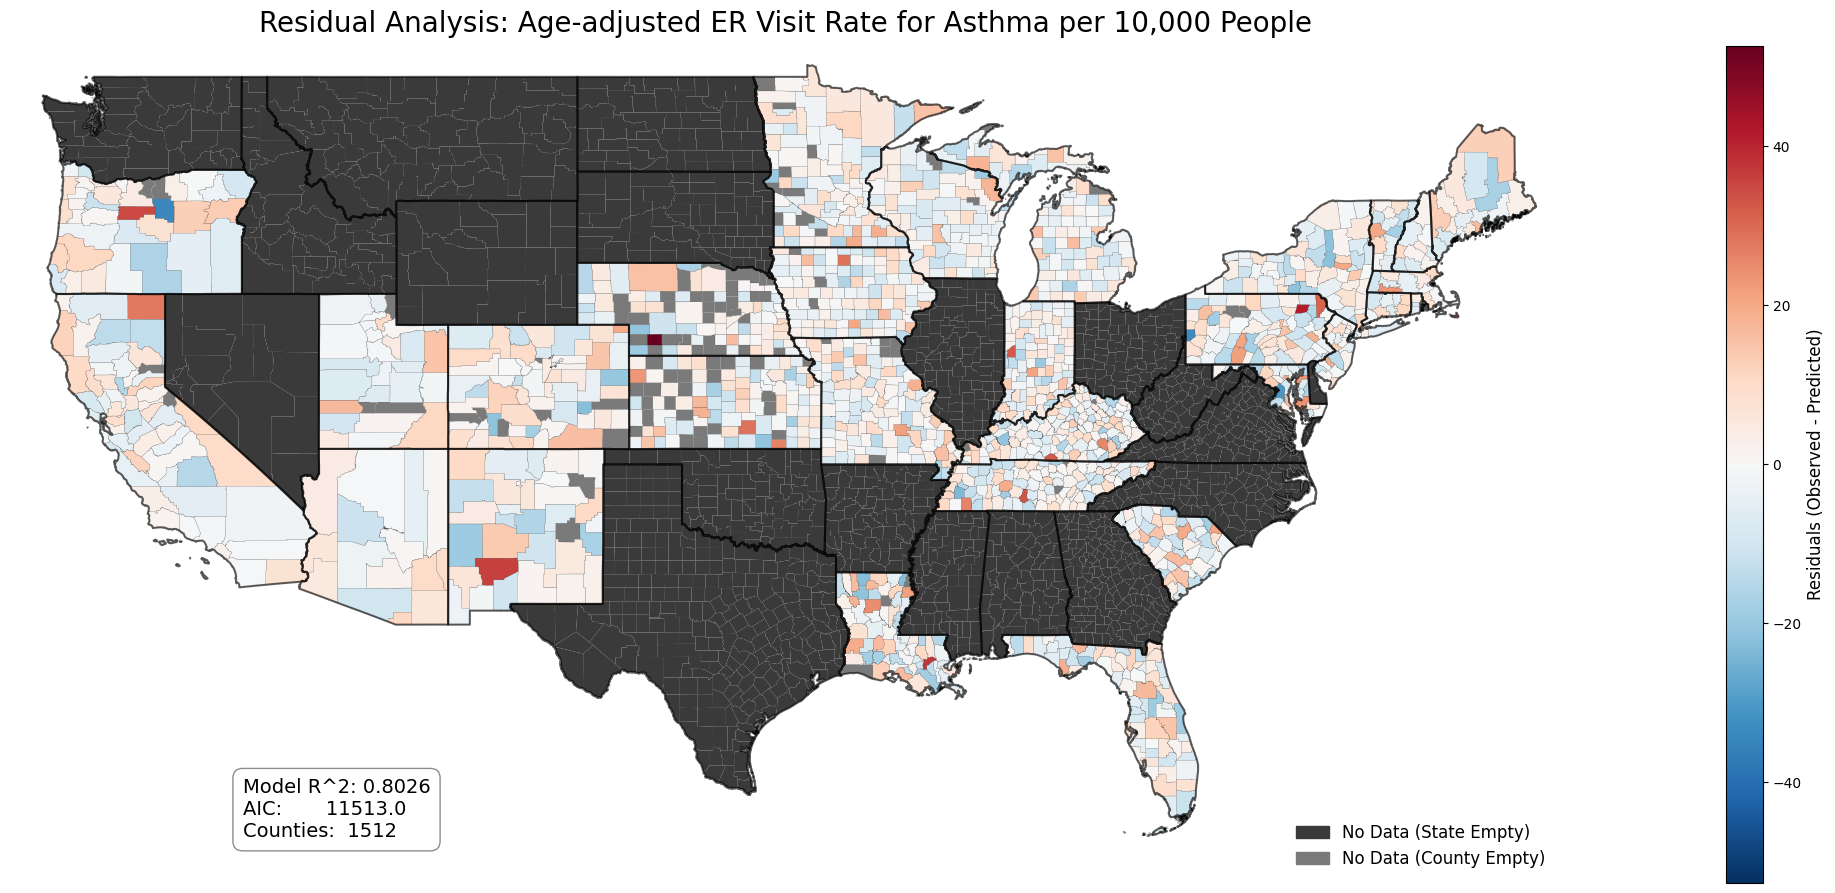

Colorbar Limit (Min/Max): +/- 11.0451
Saved: Residual Map for Age-adjusted Hospitalization Rate for Asthma per 10,000 People.png


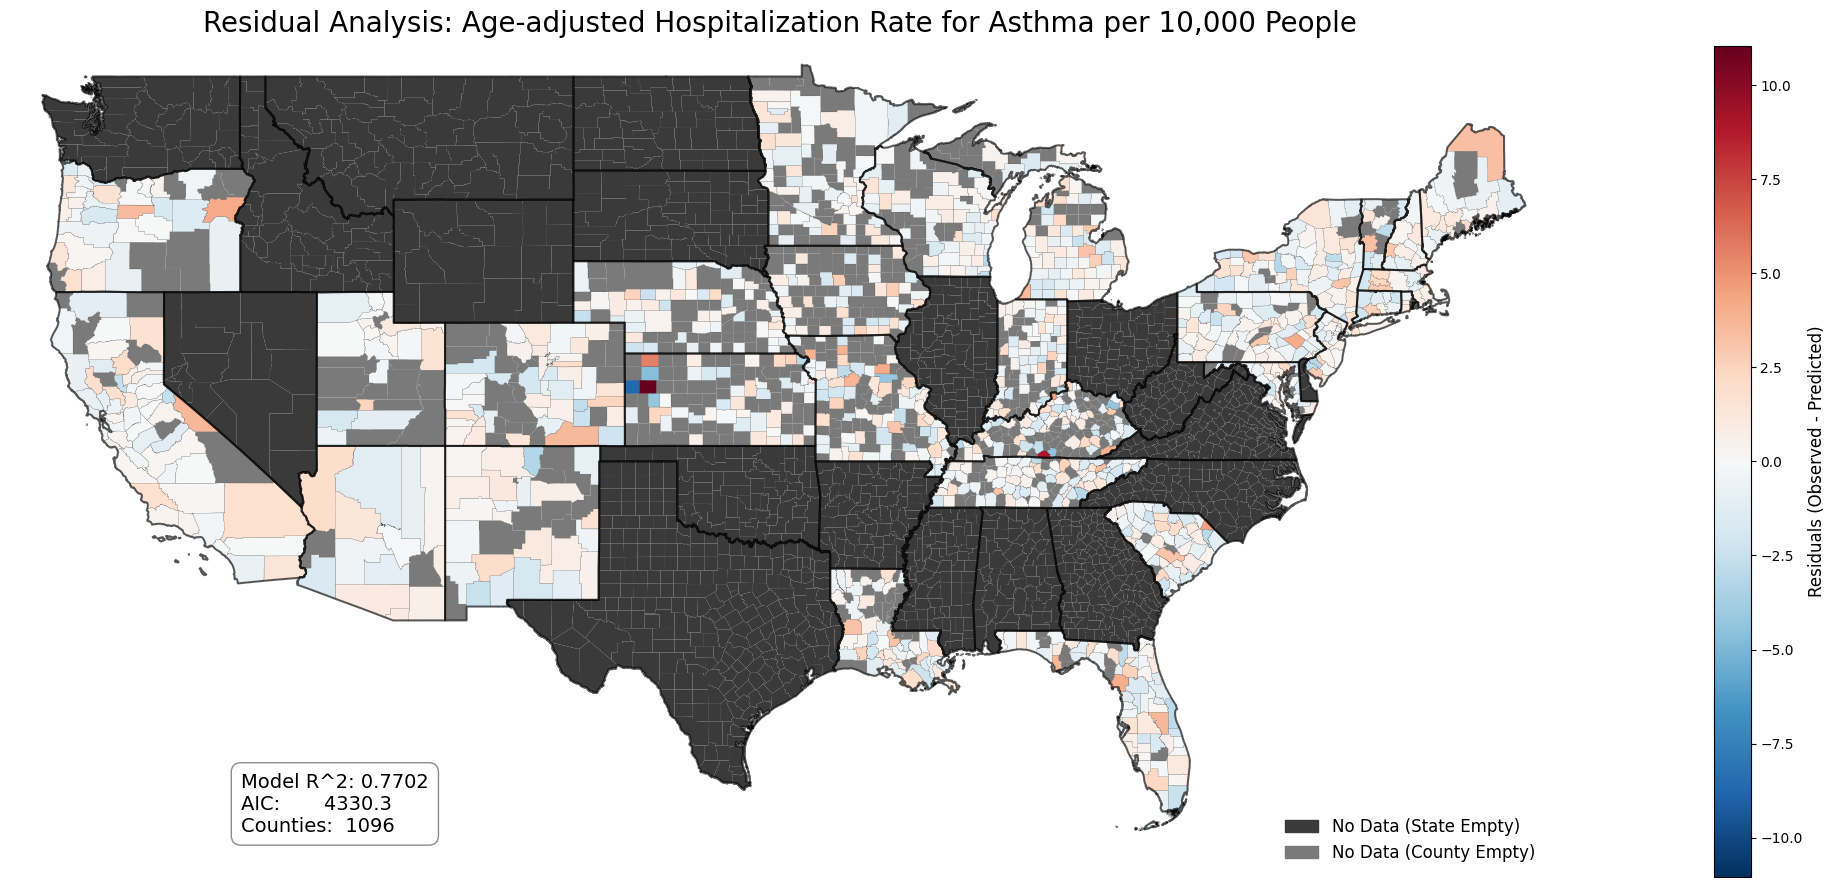

In [ ]:
# Generating residuals graph to see how the model did overall.

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def plot_residuals(gdf, lasso_results, target_name, output_folder=None, render=True):
    '''
    Plots OLS Residuals using symmetric Min/Max scaling (White = 0).
    Uses exact Min/Max of the data and attempts to maximizes map size
    for readability
    '''

    ###################### Color Settings ######################
    FULL_MISSING = '#3A3A3A'      # Dark Gray (State Empty)
    PARTIAL_MISSING = '#7A7A7A'   # Light Gray (County Empty)
    COLOR_MAP = 'RdBu_r'


    ###################### Data Prep ######################
    if target_name not in lasso_results:
        print(f'Target {target_name} not found in results.')
        return

    res = lasso_results.get(target_name)
    model = res['ols_model']

    valid_indices = model.model.data.row_labels

    plot_gdf = gdf.copy()
    plot_gdf['residuals'] = np.nan

    common_indices = plot_gdf.index.intersection(valid_indices)
    plot_gdf.loc[common_indices, 'residuals'] = model.resid.loc[common_indices]

    if 'State' in plot_gdf.columns:
        plot_gdf = plot_gdf[~plot_gdf['State'].isin(['Alaska', 'Hawaii'])]
        gdf_states = plot_gdf.dissolve(by='State')
    else:
        gdf_states = None

    mask_valid = plot_gdf['residuals'].notna()
    gdf_valid = plot_gdf[mask_valid]
    gdf_missing = plot_gdf[~mask_valid]

    valid_states = gdf_valid['State'].unique()
    mask_partial = gdf_missing['State'].isin(valid_states)
    gdf_missing_partial = gdf_missing[mask_partial]
    gdf_missing_total   = gdf_missing[~mask_partial]

    ###################### Min/Max Scaling ######################
    limit = max(abs(gdf_valid['residuals'].min()), abs(gdf_valid['residuals'].max()))
    print(f'Colorbar Limit (Min/Max): +/- {limit:.4f}')

    ###################### Plotting ######################
    # Explicitly setting figure facecolor to white to avoid IDE/System color
    # difference causing issues
    fig, ax = plt.subplots(figsize=(20, 12), facecolor='white')
    ax.set_facecolor('white')

    if not gdf_missing_total.empty:
        gdf_missing_total.plot(ax=ax, color=FULL_MISSING, edgecolor='none')

    if not gdf_missing_partial.empty:
        gdf_missing_partial.plot(ax=ax, color=PARTIAL_MISSING, edgecolor='none')

    gdf_valid.plot(column='residuals',
                   ax=ax,
                   cmap=COLOR_MAP,
                   vmin=-limit,
                   vmax=limit,
                   linewidth=0.1,
                   edgecolor='black',
                   legend=False)

    if gdf_states is not None:
        gdf_states.boundary.plot(ax=ax, color='black', linewidth=1.5, alpha=0.6)

    ###################### Color Bar & Layout ######################
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='2%', pad=0.1)

    sm = plt.cm.ScalarMappable(cmap=COLOR_MAP, norm=plt.Normalize(vmin=-limit, vmax=limit))
    sm._A = []
    cbar = fig.colorbar(sm, cax=cax)
    cbar.set_label('Residuals (Observed - Predicted)', fontsize=12)

    ax.set_title(f'Residual Analysis: {target_name}', fontsize=20, pad=10)
    ax.set_xlim([-126, -66])
    ax.set_ylim([23, 50])
    ax.axis('off')

    stats_text = (
        f'Model R^2: {model.rsquared:.4f}\n'
        f'AIC:       {model.aic:.1f}\n'
        f'Counties:  {int(model.nobs)}'
    )
    ax.text(0.15, 0.05, stats_text, transform=ax.transAxes, fontsize=14,
            verticalalignment='bottom',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='gray'))

    dark_patch = mpatches.Patch(color=FULL_MISSING, label='No Data (State Empty)')
    light_patch = mpatches.Patch(color=PARTIAL_MISSING, label='No Data (County Empty)')
    ax.legend(handles=[dark_patch, light_patch], loc='lower right', frameon=False, fontsize=12)

    plt.tight_layout()

    ###################### Saving the Graph ######################
    if output_folder:
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        safe_name = re.sub(r'[<>:"/\\|?*]', '_', target_name).strip()
        filename = f'Residual Map for {safe_name}.png'
        save_path = os.path.join(output_folder, filename)

        # FIX: Ensure facecolor is white and transparency is disabled during save
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white', transparent=False)
        print(f'Saved: {filename}')

    if render:
        plt.show()
    else:
        plt.close(fig)

#############################
output_folder = r'C:\Users\Mustafa\Desktop\asthma analysis\files\results\maps'

for TARGET in asthma_columns:
    plot_residuals(gdf_final,
                     lasso_results,
                     TARGET,
                     output_folder=output_folder,
                     render=True
                     )

In [ ]:
# This function is to plot the features' values, mostly to help visualize the
# eigenvectors and what they mean, since an abstract SF_x value is not exactly
# interpretable by itself. This is a very crucial step for interpretation
# since these features dominate the Lasso selections both by sheer
# count and by statistical significance (very high absolute OLS, very low p-value)

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_features_with_stats(gdf, coef_df, features_to_plot, target_name, output_folder=None, render=True):
    '''
    Plots feature maps for the Continental US (CONUS).
    - Hardened against black backgrounds on different systems.
    - Valid Data: Plotted with Viridis colormap.
    - Missing Data (Partial): Lighter gray/red.
    - Missing Data (Total): Dark gray.
    '''
    ###################### Colors ######################
    FULL_MISSING = '#3A3A3A'
    PARTIAL_MISSING = '#923030' 
    COLOR_SCHEME = 'viridis'
    

    ###################### Pre-Processing ######################
    # Excluding non-continental US states to be on the safe side even though we've previously deleted them
    if 'State' in gdf.columns:
        gdf = gdf[~gdf['State'].isin(['Alaska', 'Hawaii'])]
        gdf_states = gdf.dissolve(by='State')
    else:
        gdf_states = None

    ###################### Creating the Splits ######################
    missing_mask = gdf[target_name].isna()
    gdf_valid = gdf[~missing_mask]
    gdf_missing = gdf[missing_mask]

    valid_states = gdf_valid['State'].unique()
    mask_partial = gdf_missing['State'].isin(valid_states)

    gdf_missing_partial = gdf_missing[mask_partial]
    gdf_missing_total   = gdf_missing[~mask_partial]

    print(f'Valid Counties: {len(gdf_valid)}')
    print(f'Missing (Partial State): {len(gdf_missing_partial)}')
    print(f'Missing (Empty State): {len(gdf_missing_total)}')

    for feature in features_to_plot:
        if feature not in gdf.columns:
            print(f'Skipping {feature}...')
            continue

        # Get Stats
        stats = coef_df[(coef_df['Target'] == target_name) &
                        (coef_df['Feature'] == feature)]

        if stats.empty:
            stats_text = 'Stats not available'
        else:
            row = stats.iloc[0]
            stats_text = (
                f'OLS Coef: {row['OLS_Coef']:.4f}\n'
                f'P-Value:  {row['P_Value']:.4f}\n'
                f'VIF:      {row['VIF']:.2f}'
            )

        ###################### Plotting Setup ######################
        # Explicitly setting figure facecolor to white
        fig, ax = plt.subplots(figsize=(18, 12), facecolor='white')
        ax.set_facecolor('white')

        ##### LAYER 1: Total Missing (No target data in state at all)
        if not gdf_missing_total.empty:
            gdf_missing_total.plot(ax=ax, color=FULL_MISSING, edgecolor='none')

        ##### LAYER 2: Partial Missing (No target data in county, but other counties in state have data)
        if not gdf_missing_partial.empty:
            gdf_missing_partial.plot(ax=ax, color=PARTIAL_MISSING, edgecolor='none')

        ##### LAYER 3: Feature Data
        gdf_valid.plot(column=feature,
                       ax=ax,
                       cmap=COLOR_SCHEME,
                       linewidth=0.1,
                       edgecolor='white',
                       legend=True,
                       legend_kwds={'shrink': 0.4, 'pad': 0.02})

        ##### LAYER 4: State Boundaries (thicker outlines for states to help readability)
        if gdf_states is not None:
            gdf_states.boundary.plot(ax=ax, color='black', linewidth=1.5, alpha=0.6)

        ##### Titles and Stats
        ax.set_title(f'Predictor: {feature}\nTarget: {target_name}', fontsize=18)

        ax.text(0.15, 0.10, stats_text,
                transform=ax.transAxes,
                fontsize=14,
                verticalalignment='top',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='gray'))

        ##### Legends
        dark_patch = mpatches.Patch(color=FULL_MISSING, label='No Target Data (State Empty)')
        light_patch = mpatches.Patch(color=PARTIAL_MISSING, label='No Target Data (County Empty)')
        ax.legend(handles=[dark_patch, light_patch], loc='lower right', frameon=False, fontsize=12)

        ##### Standard Zoom Limits
        ax.set_xlim([-128, -65])
        ax.set_ylim([22, 52])
        ax.axis('off')

        plt.tight_layout()

        ###################### Saving the Result ######################
        if output_folder:
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)

            safe_feature_name = re.sub(r'[<>:"/\\|?*]', '_', feature).strip()
            if len(safe_feature_name) > 150:
                 safe_feature_name = safe_feature_name[:150]

            filename = f'{safe_feature_name}.png'
            save_path = os.path.join(output_folder, filename)

            # Forcing white background and disabling transparency on save
            plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white', transparent=False)
            print(f'Saved: {filename}')

        if render:
            plt.show()
        else:
            plt.close(fig)

#######################################
P_VALUE_TARGET = 0.05
VIF_TARGET = 10
TARGET = asthma_columns[1]
TOP_N = 1

output_folder = r'C:\Users\Mustafa\Desktop\asthma analysis\files\results\maps\hospitalization'

sorted_coef = coef_df.sort_values(
    by='OLS_Coef',
    key=lambda x: x.abs(),
    ascending=False
)

sorted_coef = sorted_coef[
        (sorted_coef['P_Value'] < P_VALUE_TARGET) &
        (sorted_coef['VIF'] < VIF_TARGET)
    ].copy()

top_n_features = sorted_coef[sorted_coef['Target'] == TARGET].head(TOP_N)['Feature'].tolist()
plot_features_with_stats(gdf_final,
                         sorted_coef,
                         top_n_features,
                         TARGET,
                         output_folder,
                         render=False
                         )

Valid Counties: 1096
Missing (Partial State): 518
Missing (Empty State): 1497
Saved: (Interaction) Value_Pollutant_ 1,3-butadiene_x_(Socioeconomic) Flag - the percentage of civilian unemployed is in the 90th percentile (1 = yes, 0 = no.png


In [ ]:
# Code to print and save all maps at once, since the previous code block prints based on filters
output_folder = {}
output_folder[asthma_columns[0]] = r'C:\Users\Mustafa\Desktop\asthma analysis\files\results\maps\er'
output_folder[asthma_columns[1]] = r'C:\Users\Mustafa\Desktop\asthma analysis\files\results\maps\hospitalization'

sorted_coef = coef_df.sort_values(
    by='OLS_Coef',
    key=lambda x: x.abs(),
    ascending=False
)

for TARGET in asthma_columns:
    target_features = sorted_coef[sorted_coef['Target'] == TARGET]['Feature'].tolist()
    print(len(target_features))

    plot_features_with_stats(gdf_final,
                             sorted_coef,
                             target_features,
                             TARGET,
                             output_folder[TARGET],
                             render=False
                             )

299
Valid Counties: 1512
Missing (Partial State): 102
Missing (Empty State): 1497
Saved: (Interaction) Value_Pollutant_ 1,3-butadiene_x_(Socioeconomic) Flag - the percentage of civilian unemployed is in the 90th percentile (1 = yes, 0 = no.png
Saved: SF_93.png
Saved: SF_14.png
Saved: SF_21.png
Saved: SF_24.png
Saved: SF_7.png
Saved: (Interaction) Value_Pollutant_ 1,3-butadiene_x_(Socioeconomic) Flag - the percentage of persons in poverty is in the 90th percentile (1 = yes, 0 = no).png
Saved: SF_39.png
Saved: SF_174.png
Saved: SF_90.png
Saved: SF_42.png
Saved: SF_271.png
Saved: SF_291.png
Saved: SF_457.png
Saved: SF_250.png
Saved: SF_9.png
Saved: SF_451.png
Saved: SF_513.png
Saved: SF_773.png
Saved: SF_260.png
Saved: SF_224.png
Saved: SF_143.png
Saved: SF_686.png
Saved: SF_92.png
Saved: SF_43.png
Saved: SF_710.png
Saved: SF_20.png
Saved: SF_598.png
Saved: SF_34.png
Saved: SF_736.png
Saved: SF_129.png
Saved: SF_273.png
Saved: SF_589.png
Saved: SF_77.png
Saved: SF_205.png
Saved: SF_456.pn